
## SIFA IMPLEMENTATION -- Tensorflow v2

#### Check GPU in use

In [59]:
!nvidia-smi

Sat Jun 25 11:14:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   28C    P8     9W / 250W |     16MiB / 12194MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
!python --version

Python 3.8.10


#### Clone SIFA from github

In [72]:
# Set the home path
home_path = "/home/falcetta"
%cd /home/falcetta

#!git clone https://github.com/2Falx/SIFA

/home/falcetta


In [77]:
from IPython.core.display import HTML
HTML("""<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;}
    </style>""")

In [78]:
from IPython.display import Image
Image(url="Architecture.png")

In [75]:
from IPython.display import Image
Image(url="sample_data.png")

#### Install and Import useful libraries

In [64]:
#!pip install medpy
#!python3 -m pip install --upgrade Pillow # ==> PIL
#!pip install matplotlib
#!pip install opencv-python # ==> cv2
#!pip install nibabel
#!pip install --upgrade tensorflow
#!pip install tensorflow-gpu
#!pip install tensorflow
#!pip uninstall tensorflow -y
#!pip install tqdm

In [65]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf ###
tf.disable_v2_behavior()
import os, json, random
import nibabel as nib # Library to open medical images
from medpy.io import load # Medical Validation metrics
import cv2


Instructions for updating:
non-resource variables are not supported in the long term


In [66]:
# Extract the list of all the SWI
list_SWI = [swi for swi in os.listdir("data/SWI")]
list_SWI

['OAS30002_MR_d2345',
 'OAS30005_MR_d1274',
 'OAS30009_MR_d2457',
 'OAS30003_MR_d2669',
 'OAS30014_MR_d1176',
 'OAS30015_MR_d0788',
 'OAS30009_MR_d0148',
 'OAS30009_MR_d1210',
 'OAS30005_MR_d2377',
 'OAS30006_MR_d2341',
 'OAS30001_MR_d0757',
 'OAS30011_MR_d0055',
 'OAS30006_MR_d0373',
 'OAS30004_MR_d1101',
 'OAS30007_MR_d1641',
 'OAS30005_MR_d0581',
 'OAS30004_MR_d2229',
 'OAS30008_MR_d0061',
 'OAS30003_MR_d1631',
 'OAS30007_MR_d0061']

In [67]:
# Path where all the images are contained
#/data: Contain SWI and TOF folders
#/data/SWI: Contains all the SWI images ==> 1 Folder for each patient/image
#/data/TOF: Contains all the TOF images ==> 1 Folder for each patient/image

images_path = os.path.join(home_path,"data") 

In [68]:
#Search_nii: Function that iterate over all the folder inside "images_path" and search for all the ".nii.gz" files
            #Parameters ==> 
                #"path": Path over which iterate
                #Function to apply to each file

#Extract Spacing: Create a list with all the spacings for each image

#FIRST LOOP IS TO EXTRACT SPACINGS
class extract_spacings:
    def __init__(self):
        self.spacings = []
        self.flag = [0,0]
        
    def __call__(self, img_path_data_mask):
        img_path = img_path_data_mask[0] #Just take data
        try:
            img = nib.load(img_path)
            img.get_fdata()
        except Exception:
            print("impossible to open ", img_path)
            return
        if len(img.get_fdata().shape) != 3:
            return
        pixdim = img.header["pixdim"][[3,1,2]]
        print(pixdim)
        print("\n")
        self.spacings += [pixdim]
extract_spacings = extract_spacings()

def search_nii(path, extraction):
    if os.path.isfile(path):
        if path.endswith(".nii.gz"):
            #Extract filename, patient name and modality from path
            filename = path.split("/")[-1]
            patient = path.split("/")[-3]
            modality = path.split("/")[-4]
            
            if filename.startswith("sub"): #DATA X ==> Brain image
                
                # Patient OAS30003_MR_d2682 had five different /anat folders 
                # Take just the one that contains both the brain image and the mask 
                # In this case "anat5" 
                if not (patient == "OAS30003_MR_d2682" and path.split("/")[-2] !="anat5"):
                    if modality == "TOF" and modality in filename:
                        #Save data inside the first element of this list
                        extraction.flag[0] = path
                    if modality == "SWI":
                        #Save data inside the first element of this list
                        extraction.flag[0] = path
            if filename.startswith("mask"): #MASK y ==> you can use either "vessel_filtered" or "mask"
                #Save data inside the second element of this list
                extraction.flag[1] = path 
                
            # Call the extraction function for TOF if you have saved both the data X and the mask y
            if extraction.flag[0] != 0 and extraction.flag[1] !=0: #TOF
                print("Extraction\n", os.path.relpath(extraction.flag[0],home_path),"\n", os.path.relpath(extraction.flag[1],home_path))
                extraction(extraction.flag)
                extraction.flag = [0,0]
                
            # Call the extraction function for SWI if you have saved just the data X (You do not have any mask for SWI)
            if modality == "SWI" and extraction.flag[0] != 0: #SWI
                #print("Extraction\n", os.path.relpath(extraction.flag[0],home_path),"\n", os.path.relpath(extraction.flag[1],home_path))
                print("Extraction\n", os.path.relpath(extraction.flag[0],home_path),"\n", extraction.flag[1])
                extraction(extraction.flag)
                extraction.flag = [0,0]
                
                
    else:
        for subpath in os.listdir(path):
            subpath = os.path.join(path, subpath)
            search_nii(subpath, extraction)



In [69]:
#EXTRACT SPACINGS for each Images
search_nii(images_path, extract_spacings)
print("DONE")

Extraction
 data/TOF/OAS30003_MR_d3320/anat1/sub-OAS30003_ses-d3320_acq-TOF_angio.nii.gz 
 data/TOF/OAS30003_MR_d3320/anat1/mask.nii.gz
[0.5999967  0.29947916 0.29947916]


Extraction
 data/TOF/OAS30008_MR_d1327/anat1/sub-OAS30008_ses-d1327_acq-TOF_angio.nii.gz 
 data/TOF/OAS30008_MR_d1327/anat1/mask.nii.gz
[0.5999985  0.29947916 0.29947916]


Extraction
 data/TOF/OAS30009_MR_d2457/anat1/sub-OAS30009_ses-d2457_acq-TOF_angio.nii.gz 
 data/TOF/OAS30009_MR_d2457/anat1/mask.nii.gz
[0.5999985  0.29947916 0.29947916]


Extraction
 data/TOF/OAS30001_MR_d2430/anat1/sub-OAS30001_ses-d2430_acq-TOF_angio.nii.gz 
 data/TOF/OAS30001_MR_d2430/anat1/mask.nii.gz
[0.5999985  0.29947916 0.29947916]


Extraction
 data/TOF/OAS30013_MR_d0102/anat1/sub-OAS30013_ses-d0102_acq-TOF_angio.nii.gz 
 data/TOF/OAS30013_MR_d0102/anat1/mask.nii.gz
[0.4999975  0.26041666 0.26041666]


Extraction
 data/TOF/OAS30025_MR_d2298/anat1/sub-OAS30025_ses-d2298_acq-TOF_angio.nii.gz 
 data/TOF/OAS30025_MR_d2298/anat1/mask.nii.gz

In [231]:
#Spacing SWI ==>[1.99999541 0.8984375  0.8984375 ]
#Spacing TOF ==>[0.59999847 0.29947916 0.29947916]

print(f"Number of total patient ==> {len(extract_spacings.spacings)}\n")
# Change the percentile value to find the needed spacings 
SPACING_SWI = np.percentile(np.array(extract_spacings.spacings), 50, 0)
SPACING_TOF = np.percentile(np.array(extract_spacings.spacings), 40, 0)
print(f"Spacing SWI ==>{SPACING_SWI}\nSpacing TOF ==>{SPACING_TOF}")

SPACING = SPACING_SWI # Use the SWI spacing to resize all the images
print(f"\nChosen Spacing: {SPACING}")


Number of total patient ==> 38

Spacing SWI ==>[1.99999541 0.8984375  0.8984375 ]
Spacing TOF ==>[0.59999847 0.29947916 0.29947916]

Chosen Spacing: [1.99999541 0.8984375  0.8984375 ]


In [45]:
# SPACING = [1.99999541, 0.8984375,  0.8984375 ] #SWI

In [232]:
# REMOVE ALL THE FOLDER FROM PREVIOUS RUNS
!rm -r numpy
!rm -r preprocessed
!rm -r new_tfrecords

In [233]:
#SECOND LOOP IS TO RESIZE AND EXTRACT SLICES

import os
from skimage.transform import resize
from batchgenerators.augmentations.utils import resize_segmentation

def rescaleVolume(image, spacing_target, current_spacing, is_seg=False):
    spacing_target[0] = current_spacing[0] # Mantain the same spacing for the z dimension
    new_shape = np.round(current_spacing / spacing_target * image.shape).astype(int)
    if not is_seg:
        print(f"data dtype ==> {image.dtype}")
        image = resize(image, new_shape, 3, cval=0, mode='edge', anti_aliasing=False)
        #image.dtype ==> np.FLOAT64
    else:
        print(f"mask dtype ==> {image.dtype}")
        image = resize_segmentation(image, new_shape, order=1)
    return image

class extract_slices:
    def __init__(self):
        self.flag = [0,0]
        self.min_values = []
        self.max_values = []
        self.mean_values = []
        self.std_values = []

        if not os.path.isdir("numpy"):
            os.makedirs("numpy")
    
    def __call__(self, img_path_data_mask):
        img_path = img_path_data_mask[0] #data X
        mask_path = img_path_data_mask[1] #mask y
        modality = img_path_data_mask[0].split("/")[-4] #TOF/SWI
        try:
            # Load nib images and extract numpy
            img = nib.load(img_path)
            img.get_fdata()
        except Exception:
            print("impossible to open ", img_path)
            return
        
        try:
            if modality == "SWI":
                #Zero mask for a SWI image
                mask = np.zeros(img.shape)
            else:
                #Extract numpy mask for a TOF image
                mask = nib.load(mask_path)
                mask = mask.get_fdata()
        
        except Exception:
            print("impossible to open ", mask_path)
            return
            
        
        # Assert the correct dimesions for image and mask 
        if len(img.get_fdata().shape) != 3 or len(mask.shape) != 3:
            return
        
        # From (x,y,z) to (z,x,y) to iterate over the z-dimension
        pixdim = img.header["pixdim"][[3,1,2]] 
        img = img.get_fdata().transpose(2, 0, 1)
        
        old_shape = img.shape
        #Rescale image volume according to the chosen spacing
        img = rescaleVolume(img, SPACING, pixdim)
    
        #Rescale mask volume according to the chosen spacing
        #Segmentation mask ==> is_seg=True
        mask = mask.transpose(2,0,1)
        mask = rescaleVolume(mask, SPACING, pixdim, is_seg=True)

        # Update dataset statistics for each images
        self.min_values += [np.min(img)]# * len(img)
        self.max_values += [np.max(img)]# * len(img)
        self.mean_values += [np.mean(img)]# * len(img)
        self.std_values += [np.std(img)]# * len(img)
        
        
        out_path = os.path.split(img_path)[1].replace(".nii.gz", "")
        print(f"Rescale Volume: {old_shape} ==> {img.shape}\n")
        
        # Iterate over the slices for each pair (data X, mask y)
        for iter, (slice_img, slice_mask) in enumerate(zip(img,mask)):
            # Save a numpy dictionary for each slice
            np.save("numpy/{}_slice{:02d}.npy".format(out_path, iter),
            {
                "data": slice_img, 
                "mask": slice_mask, 
                "spacing": pixdim, 
                "max": self.max_values[-1], 
                "min": self.min_values[-1], 
                "mean": self.mean_values[-1], 
                "std": self.std_values[-1]
            })
extract_slices = extract_slices()



print(f"CURRENT SPACING ==> {SPACING}\n\n")
search_nii(images_path, extract_slices) #As before but extract slices for each (Data X, Mask y) pair
print("DONE")

CURRENT SPACING ==> [1.99999541 0.8984375  0.8984375 ]


Extraction
 data/TOF/OAS30003_MR_d3320/anat1/sub-OAS30003_ses-d3320_acq-TOF_angio.nii.gz 
 data/TOF/OAS30003_MR_d3320/anat1/mask.nii.gz
data dtype ==> float64
mask dtype ==> float64
Rescale Volume: (136, 576, 768) ==> (136, 192, 256)

Extraction
 data/TOF/OAS30008_MR_d1327/anat1/sub-OAS30008_ses-d1327_acq-TOF_angio.nii.gz 
 data/TOF/OAS30008_MR_d1327/anat1/mask.nii.gz
data dtype ==> float64
mask dtype ==> float64
Rescale Volume: (232, 576, 768) ==> (232, 192, 256)

Extraction
 data/TOF/OAS30009_MR_d2457/anat1/sub-OAS30009_ses-d2457_acq-TOF_angio.nii.gz 
 data/TOF/OAS30009_MR_d2457/anat1/mask.nii.gz
data dtype ==> float64
mask dtype ==> float64
Rescale Volume: (232, 576, 768) ==> (232, 192, 256)

Extraction
 data/TOF/OAS30001_MR_d2430/anat1/sub-OAS30001_ses-d2430_acq-TOF_angio.nii.gz 
 data/TOF/OAS30001_MR_d2430/anat1/mask.nii.gz
data dtype ==> float64
mask dtype ==> float64
Rescale Volume: (232, 576, 768) ==> (232, 192, 256)

Ext

In [48]:
## Some examples of rescaling 

#Using SPACING_SWI {
#Extraction ==> OAS30013_MR_d0102
#Rescale Volume: (z, 696, 768) ==> (z, 202, 223)

#TOF
#Rescale Volume: (z, 576, 768) ==> (z, 192, 256)

#SWI
#Rescale Volume: (z, 192, 256) ==> (z, 192, 256)
#         }



#Using SPACING_TOF {
#Extraction ==> OAS30013_MR_d0102
#Rescale Volume: (z, 696, 768) ==> (z, 605, 668)

#TOF
#Rescale Volume: (z, 576, 768) ==> (z, 576, 768)

#SWI
#Rescale Volume: (z, 192, 256) ==> (z, 576, 768)
#         }  #==> MEMORY ISSUE

### Display some slices from "numpy" directory

(256, 192)


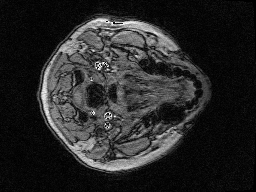

In [234]:
import os
from PIL import Image
os.listdir("numpy")

img = Image.fromarray(np.load("numpy/sub-OAS30008_ses-d1327_acq-TOF_angio_slice18.npy", allow_pickle=True).item()["data"].astype(np.uint8))
print(img.size)
img

(256, 192)


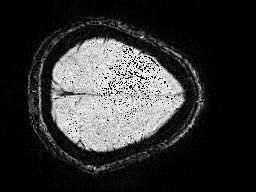

In [235]:
img = Image.fromarray(np.load("numpy/sub-OAS30005_ses-d0581_swi_slice65.npy", allow_pickle=True).item()["data"].astype(np.uint8))
print(img.size)
img

(223, 202)


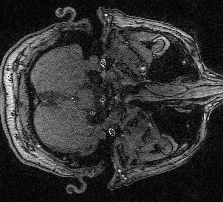

In [236]:
img = Image.fromarray(np.load("numpy/sub-OAS30013_ses-d0102_acq-TOF_angio_slice30.npy", allow_pickle=True).item()["data"].astype(np.uint8))
print(img.size)
img

### Extract useful statistics from our dataset

In [237]:
MAX = np.max(extract_slices.max_values)
MIN = np.min(extract_slices.min_values)
MEAN = np.mean(extract_slices.mean_values)
STD = np.sqrt(1/len(extract_slices.std_values) * np.sum(np.power(extract_slices.std_values, 2)))
STANDARDIZE_MAX = np.max(np.subtract(extract_slices.max_values, extract_slices.mean_values) / np.add(extract_slices.std_values, 1e-8))
STANDARDIZE_MIN = np.min(np.subtract(extract_slices.min_values, extract_slices.mean_values) / np.add(extract_slices.std_values, 1e-8))

In [238]:
print(MAX,MIN,MEAN,STD,STANDARDIZE_MAX,STANDARDIZE_MIN)

1032.0 0.0 56.03965745242126 70.0058855782567 13.203064826006445 -1.2809882331461449


In [55]:
# Default statistics for the used dataset
def assign_stats():
    MAX = 1032.0 
    MIN = 0.0
    MEAN = 56.03965745242126
    STD = 70.0058855782567
    STANDARDIZE_MAX = 13.203064826006445 
    STANDARDIZE_MIN = -1.2809882331461449
    return MAX,MIN,MEAN,STD,STANDARDIZE_MAX,STANDARDIZE_MIN

MAX,MIN,MEAN,STD,STANDARDIZE_MAX,STANDARDIZE_MIN = assign_stats()

In [56]:
print(MAX,MIN,MEAN,STD,STANDARDIZE_MAX,STANDARDIZE_MIN)

1032.0 0.0 56.03965745242126 70.0058855782567 13.203064826006445 -1.2809882331461449


In [239]:
def standardizeSlice(image, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(image)
        std = np.std(image)
    image -= mean
    image /= std + 1e-8
    return image

def normalizeSlice(image, max=None, min=None):
    if max is None or min is None:
        max = np.max(image)
        min = np.min(image)
    image -= min
    image *= 2
    image /= max - min
    image -= 1
    return image

def padding(img, new_shape, pad_value = 0):
    shape = tuple(list(img.shape))
    new_shape = tuple(np.max(np.concatenate((shape, new_shape)).reshape((2, len(shape))), axis=0))
    res = np.ones(list(new_shape), dtype=img.dtype) * pad_value
    start = np.array(new_shape) / 2. - np.array(shape) / 2.
    res[int(start[0]) : int(start[0]) + int(shape[0]), int(start[1]) : int(start[1]) + int(shape[1])] = img
    return res
    
def center_crop(slice, center_crop):
    if(all(np.array(slice.shape) <= center_crop)):
        return slice
    center = np.array(slice.shape) / 2.
    return slice[int(center[0] - center_crop[0] / 2.) : int(center[0] + center_crop[0] / 2.), int(center[1] - center_crop[1] / 2.) : int(center[1] + center_crop[1] / 2.)]

def one_hot(seg,num_classes=2):
    # N.B. ".astype(np.float32)" to obtain the correct datatype !!!!!
    return np.eye(num_classes)[seg.astype(int)].astype(np.float32)

def add_dim(img):
    new_img = img[:, :, np.newaxis].astype(np.float32)
    #print(f'Old Shape: {img.shape} ==> New Shape: {new_img.shape}')
    return new_img

def preprocessSlice(img, type="data"):
    img = padding(img, (352,352))
    img = center_crop(img, (352,352))
    if type == "mask":
        img = one_hot(img) #(x,x)--> (x,x,num_classes) #In our case num_classes=2 
    else:
        img = add_dim(img) #(x,x)--> (x,x,1)
    return img

In [58]:
!rm -r preprocessed
!rm -r new_tfrecords

rm: cannot remove 'preprocessed': No such file or directory
rm: cannot remove 'new_tfrecords': No such file or directory


### Iterate and process each numpy slice

In [240]:
if not os.path.isdir("preprocessed"):
    os.makedirs("preprocessed")

    
from tqdm import tqdm
for slice_id in tqdm(os.listdir("numpy")):
    slice_path = os.path.join("numpy", slice_id)
    # allow_pickle=True to load the entire dictionary
    slice = np.load(slice_path, allow_pickle=True).item()
    # mean and std of the slice VOLUME
    slice["data"] = standardizeSlice(slice["data"],  slice["mean"], slice["std"]) 
    # standatdize MIN and MAX over all the dataset
    slice["data"] = normalizeSlice(slice["data"], STANDARDIZE_MAX, STANDARDIZE_MIN) 
    
    # Preprocess Data and Mask: Padding, Center_Crop, Add_dim/One_hot
    slice["data"] = preprocessSlice(slice["data"])
    slice["mask"] = preprocessSlice(slice["mask"], type="mask")
  
    #Save a dictionary with preprocessed data and mask for each slice
    np.save("preprocessed/{}".format(slice_id), {
        "data": slice["data"],
        "mask": slice["mask"]})
    
    #np.save("preprocessed/{}".format(slice_id), slice["data"])
    
print("DONE")

100%|██████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:23<00:00, 232.24it/s]

DONE


In [241]:
def numpy2tfrecords(data_vol_val,label_vol_val,tfrecord_pth):
    # Adapted from SIFA repo:
    #data_vol_val: preprocessed slice
    #label_vol_val: corresponding mask
    
    #print(tfrecord_pth)
    
    #Select the correct file (TOF or SWI) in which to append the tfrecord
    file = "TOF_tot.txt" if "TOF" in tfrecord_pth else "SWI_tot.txt"
    
    #file_path
    file = os.path.join(os.path.dirname(tfrecord_pth),file)
    
    #print(f'Complete Path: {tfrecord_pth}')
    #print(f'Appending path to: {file}...')
    
    with open(file, "a") as file_object:
        # Append tfrecord_path at the end of the file
        file_object.write(f'{os.path.join(home_path,tfrecord_pth)}\n')     
    
    
    # N.B. Assert the correct shape and datatype 
    assert data_vol_val.shape == (352,352,1) and data_vol_val.dtype == np.float32
    # label_vol_val ==> (352,352,n) where n is the number of classes
    assert label_vol_val.shape == (352,352,2) and label_vol_val.dtype == np.float32
    
    dsize_dim0_val =  data_vol_val.shape[0] #352
    dsize_dim1_val =  data_vol_val.shape[1] #352
    dsize_dim2_val =  data_vol_val.shape[2] #1
    lsize_dim0_val = label_vol_val.shape[0] #352
    lsize_dim1_val = label_vol_val.shape[1] #352
    lsize_dim2_val = label_vol_val.shape[2] #2
    
    if lsize_dim2_val != 2:
        print(lsize_dim2_val) #==> All lsize_dim2_val must be 2 (number of classes)

    # writer = tf.python_io.TFRecordWriter(tfrecord_pth) # ==> module 'tensorflow' has no attribute 'python_io'
    writer = tf.io.TFRecordWriter(tfrecord_pth)

    feature = {
        'data_vol'  : tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(data_vol_val.tostring())])),
        'dsize_dim0': tf.train.Feature(int64_list=tf.train.Int64List(value=[dsize_dim0_val])),
        'dsize_dim1': tf.train.Feature(int64_list=tf.train.Int64List(value=[dsize_dim1_val])),
        'dsize_dim2': tf.train.Feature(int64_list=tf.train.Int64List(value=[dsize_dim2_val])),
        'lsize_dim0': tf.train.Feature(int64_list=tf.train.Int64List(value=[lsize_dim0_val])),
        'lsize_dim1': tf.train.Feature(int64_list=tf.train.Int64List(value=[lsize_dim1_val])),
        'lsize_dim2': tf.train.Feature(int64_list=tf.train.Int64List(value=[lsize_dim2_val])),
        'label_vol' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(label_vol_val.tostring())]))
      }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    #parser = tf.parse_single_example(example.SerializeToString(), features=decomp_feature)
    #label_vol = tf.decode_raw(parser['label_vol'], tf.float32)
    #label_vol = tf.reshape(label_vol, [352, 352, 2])
    #raise Exception(label_vol.shape)
    
    writer.write(example.SerializeToString())
    writer.close()
    #print(data_vol_val.shape,label_vol_val.shape)
    return

In [61]:
!rm -r new_tfrecords
!rm -r mask_tfrecords

rm: cannot remove 'new_tfrecords': No such file or directory


In [242]:
#Give a name in which to save the tfrecords
tfrecords_folder = "mask_tfrecords"

# Create folders for the tfrecords
if not os.path.isdir(tfrecords_folder):
    os.makedirs(tfrecords_folder)
if not os.path.isdir(f"{tfrecords_folder}/TOF"):
    os.makedirs(f"{tfrecords_folder}/TOF")
if not os.path.isdir(f"{tfrecords_folder}/SWI"):
    os.makedirs(f"{tfrecords_folder}/SWI")

#Iterate over the preprocessed slices
for slice_id in tqdm(os.listdir("preprocessed")):
    slice_path = os.path.join("preprocessed", slice_id)
    slice = np.load(slice_path, allow_pickle=True).item()
    
    data_vol_val = slice["data"]
    label_vol_val = slice["mask"] 
    
    mod = "TOF" if "TOF" in slice_id else "SWI"
    tfrecord_pth = os.path.join(tfrecords_folder,mod,slice_id).replace("npy", "tfrecord")
    
    numpy2tfrecords(data_vol_val,label_vol_val,tfrecord_pth)
    
print("DONE")

  0%|                                                                                          | 0/5480 [00:00<?, ?it/s]/tmp/ipykernel_974332/1841879556.py:30: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data_vol'  : tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(data_vol_val.tostring())])),
/tmp/ipykernel_974332/1841879556.py:37: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'label_vol' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(label_vol_val.tostring())]))
100%|███████████████████████████████████████████████████████████████████████████████| 5480/5480 [01:24<00:00, 65.22it/s]

DONE


In [243]:
#SPLIT TRAINING DATA INTO TRAINING + VALIDATION (By splitting the txt file containing all the tfrecord)
def split_file(file,out1,out2,percentage=0.80,isShuffle=True,seed=123): 
#Splits a file in 2 given the needed `percentage` of the larger shard
    random.seed(seed) 
    with open(file, 'r',encoding="utf-8") as fin, open(out1, 'w') as foutBig, open(out2, 'w') as foutSmall: 
        nLines = sum(1 for line in fin) 
        fin.seek(0) 

        nTrain = int(nLines*percentage)  
        nValid = nLines - nTrain 

        i = 0 
        for line in fin: 
            r = random.random() if isShuffle else 0 # so that always evaluated to true when not isShuffle 
            if (i < nTrain and r < percentage) or (nLines - i > nValid): 
                foutBig.write(line) 
                i += 1 
            else: 
                foutSmall.write(line) 

In [244]:
#"mask_tfrecords" or "new_tfrecords"
SWI_tot="/home/falcetta/mask_tfrecords/SWI/SWI_tot.txt"
SWI_training="/home/falcetta/mask_tfrecords/SWI/trainingSWI.txt"
SWI_validation="/home/falcetta/mask_tfrecords/SWI/validationSWI.txt"

split_file(SWI_tot,SWI_training,SWI_validation)

TOF_tot="/home/falcetta/mask_tfrecords/TOF/TOF_tot.txt"
TOF_training="/home/falcetta/mask_tfrecords/TOF/trainingTOF.txt"
TOF_validation="/home/falcetta/mask_tfrecords/TOF/validationTOF.txt"

split_file(TOF_tot,TOF_training,TOF_validation)

In [65]:
def check_num_classes():
    #Check if some mask contains more or less the our number of classes
    flag = 0
    #Iterate over the preprocessed slices
    for numpy_dict in tqdm(os.listdir("preprocessed")):
        if numpy_dict.endswith("npy"):
            dict_path = os.path.join("preprocessed", numpy_dict)
            dataset=np.load(dict_path, allow_pickle = True).item()
            vol_mask = dataset["mask"]
            classes = np.unique(vol_mask)
            if classes[0] != 0 or classes[1] != 1:
                print("NOT JUST 0 and 1 CLASSES")
                print(classes)
               
                flag=1
                
          
    if flag == 0:
        print("DONE WITHOUT ANY ERROR: Just 2 classes") # ==> TESTED

#check_num_classes()

# JUST 0 and 1 classes

In [206]:
# Remove previous SIFA outputs to save space
def remove_prev_output():
    %cd /home/falcetta/SIFA/output
    !rm -r *
    print("OUTPUTS REMOVED")
    
#remove_prev_output()

# Remove other folders

# %cd /home/falcetta/horse2zebra
# !rm -r *
# %cd /home/falcetta/numpy
# !rm -r *
# %cd /home/falcetta/preprocessed
# !rm -r *
# %cd /home/falcetta/SIFA/numpy
# !rm -r *
# %cd /home/falcetta/SIFA/preprocessed
# !rm -r *

/home/falcetta/SIFA/output
OUTPUTS REMOVED


In [207]:
%cd /home/falcetta

/home/falcetta


In [208]:
#Change the configuration file "config_param.json" in the SIFA folder:
    #Change "new_tfrecords" with the used "tfrecords_folder"

    #"source_train_pth": "/home/falcetta/new_tfrecords/TOF/trainingTOF.txt",
    #"target_train_pth": "/home/falcetta/new_tfrecords/SWI/trainingSWI.txt",
    #"source_val_pth": "/home/falcetta/new_tfrecords/TOF/validationTOF.txt",
    #"target_val_pth": "/home/falcetta/new_tfrecords/SWI/validationSWI.txt",

In [ ]:
#Training

#Parameter to set in the config.param.json:
    '''
    "source_train_pth": File txt containing the training tfrecord for the source domain (TOF)
    "target_train_pth": File txt containing the training tfrecord for the target domain (SWI)
    "source_val_pth": File txt containing the validation tfrecord for the source domain (TOF)
    "target_val_pth":File txt containing the validation tfrecord for the target domain (SWI)
    
    "num_cls": Number of classes, it depends on the used mask. (2 in our case: [background,brain/vessel])
    "max_step": Number of step you want train   
    "batch_size": default:4 (values above 8 had some problem with the Eurecom GPU)
    '''

#Parameter to set in the main.py
    '''
    save_interval = Save image outputs and models each xxx steps
    evaluation_interval = Evaluate loss each xxx steps
    save_loss_cnt = Save losses in the files each xxx iterations
    seg_param = Segmentation Losses ON/OFF: put 0 to set all the segmentation losses to 0
    '''


%cd /home/falcetta/SIFA
!python main.py
print("END OF TRAINING")

/home/falcetta/SIFA
Instructions for updating:
non-resource variables are not supported in the long term

CALL SIFA CONSTRUCTOR ==> Take params from config file


Call train ==> Loading Dataset....

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct 

### How to Interpret results

In [58]:
'''
    Results in the folder .../SIFA/ouput/{wanted_date}
    imgs: Contains all the .jpg images that you can find in the .html files
    nib_imgs: Same of imgs but containt the .nii.gz
    losses: Contains the .txt files of all the loss, both individually in each file and all-toghether in tot_losses.csv
'''

'''
    html visualization files:
    Read 2 rows at a time:
        1st Row ==> 6 Data images: 
                    X_s,X_t,
                    X_s>t,X_t>s,
                    X_s~,X_t~
                    
        2nd Row ==> 7 Segmentation images:
                    'pred_mask_a','pred_mask_b','pred_mask_b_ll',
                    'pred_mask_fake_a','pred_mask_fake_b','pred_mask_fake_b_ll',
                    'gt' 
'''

from IPython.display import Image
Image(url="sample_result.png")


In [57]:
from IPython.display import Image
Image(url="vessel_result.png")

### Print losses

In [380]:
%cd /home/falcetta/SIFA

import os
import pandas as pd
#Change "date" according to the name of the wanted output
date = "20220615-113621"
path = os.path.join(os.getcwd(),"output",date,"losses")


/home/falcetta/SIFA


In [381]:
losses = ["  d_B ", "d_P_ll","s_B_merge_summ",'[  g_B ','  d_A ',' d_P  ','[  g_A '] # 0-6
DF_list = list()
files =[x for x in os.listdir(path) if x.endswith(".txt")]

#Iterate over all the single-loss files
for i,loss_file in enumerate(files):
    with open(os.path.join(path,loss_file),"r") as file:
        
        if loss_file == "s_B_loss_merge_summ.txt":
            DF_list.append(pd.read_csv(file,index_col=False))
        
        elif loss_file.startswith("g_loss"):
            df = pd.read_csv(file,header=None)
            if loss_file == "g_loss_B.txt":
                df.drop(columns=df.columns[3], axis=1, inplace = True)
                df.rename(columns={0:losses[i],1:"cycl_b",2:"tot_gb]"}, inplace=True)
            else:
                df.rename(columns={3:" iter #"}, inplace=True)
                df.rename(columns={0:losses[i],1:"cycl_a",2:"tot_ga]"}, inplace=True)
            

            DF_list.append(df)
        
        else:
            #csv to dataframe
            df = pd.read_csv(file,header=None)
            #drop the iteration column
            df.drop(columns=df.columns[1], axis=1,inplace=True)
            df.rename(columns={0:losses[i]}, inplace=True)
            DF_list.append(df)
            

for i,df in enumerate(DF_list):
    # Concatenate each loss in a single dataframe
    if i==0:
        tot_df = df
    else:
        tot_df = pd.concat([tot_df, df], axis=1)

#Save a file containing all the losses
tot_df.to_csv(f"{path}/tot_losses.csv",float_format='%4.4f',index=False)

#REMOVE BIG FILES ==> Model savings

#%cd /home/falcetta/SIFA/output/{date}
#!rm sifa*data*
#!rm *.meta


/tmp/ipykernel_974332/2164729415.py:10: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  DF_list.append(pd.read_csv(file,index_col=False))


## Plot Losses

In [1]:
%cd /home/falcetta
!find . -name "tot_losses.csv" > loss_path.txt
!find . -name "tot_losses.csv"

/home/falcetta
./SIFA/results_ok/test_20220610-161051_(InvertedSourceTarget)/losses/tot_losses.csv
./SIFA/results_ok/test_20220611-101159_40k/losses/tot_losses.csv
./SIFA/output/20k_no_segment_20220614-215749/losses/tot_losses.csv
./SIFA/output/40k+mask_20220613-120103/losses/tot_losses.csv
./SIFA/output/20220615-113621/losses/tot_losses.csv


In [2]:
def preprocess_line(line):
    #line = line.split(",")
    line=line.replace("[","")
    line=line.replace("]","")
    line=line.replace("\n","")
    line=line.replace("iter:","")
    line=line.replace("'","")
    line=line.replace(" ","")
    return line

In [3]:
with open("loss_path.txt","r") as files_list:
    for file in files_list:
        print(file)

./SIFA/results_ok/test_20220610-161051_(InvertedSourceTarget)/losses/tot_losses.csv

./SIFA/results_ok/test_20220611-101159_40k/losses/tot_losses.csv

./SIFA/output/20k_no_segment_20220614-215749/losses/tot_losses.csv

./SIFA/output/40k+mask_20220613-120103/losses/tot_losses.csv

./SIFA/output/20220615-113621/losses/tot_losses.csv



In [4]:
import pandas as pd
%cd /home/falcetta
#Select a file from the above list
file_name = "./SIFA/output/40k+mask_20220613-120103/losses/tot_losses.csv"
df = pd.DataFrame(columns = ['d_B', 'd_P_ll', 'ce_B', 'dice_B', 'l2_B', 'seg_B', 'g_B', 'cycl_b', 'tot_gb', 'd_A', 'd_P', 'g_A', 'cycl_a', 'tot_ga', 'iter#'])

with open(file_name,"r") as f:
    for i,line in enumerate(f):
        line = preprocess_line(line)
        line = line.split(",")
        if i!=0:
            df.loc[len(df)] = line

        
df

/home/falcetta


,d_B,d_P_ll,ce_B,dice_B,l2_B,seg_B,g_B,cycl_b,tot_gb,d_A,d_P,g_A,cycl_a,tot_ga,iter#
0,0.5246,0.3384,0.0013,0.5849,0.7222,1.9517,0.8082,1.2384,3.3947,0.9947,0.5581,0.9883,1.3770,3.9087,0
1,0.2709,0.2964,0.0004,0.5180,0.7045,1.4545,0.2935,0.2313,0.9851,0.5013,0.3723,0.2694,0.4577,1.0399,100
2,0.2669,0.2517,0.0005,0.3375,0.7031,1.2306,0.2812,0.1989,1.0231,0.5069,0.2601,0.3096,0.5653,1.1266,200
3,0.2600,0.2530,0.0007,0.2586,0.6989,1.1351,0.2710,0.1620,0.9409,0.4820,0.2542,0.2903,0.4979,0.9206,300
4,0.2545,0.2473,0.0003,0.2343,0.6941,1.1073,0.2647,0.1220,0.9415,0.4626,0.2530,0.3448,0.4618,0.8551,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0004,0.0976,0.0005,0.4802,0.3974,2.4767,0.9772,13.4354,14.0793,0.3984,0.1818,0.3222,0.3150,14.7773,39500
396,0.0002,0.1048,0.0015,0.4623,0.3957,2.3941,1.0104,13.2210,13.8493,0.4194,0.1340,0.2825,0.3509,14.5568,39600
397,0.0004,0.1036,0.0016,0.4453,0.3939,2.3519,1.0257,13.0941,13.7137,0.4342,0.1439,0.2861,0.3375,14.4065,39700
398,0.0001,0.1033,0.0022,0.4472,0.3924,2.3439,1.0019,13.1388,13.8398,0.4237,0.3428,0.3308,0.3718,14.5089,39800


In [5]:
print(df.dtypes)
for col in df.columns:
    df[col]=df[col].astype(float)

d_B       object
d_P_ll    object
ce_B      object
dice_B    object
l2_B      object
seg_B     object
g_B       object
cycl_b    object
tot_gb    object
d_A       object
d_P       object
g_A       object
cycl_a    object
tot_ga    object
iter#     object
dtype: object


In [43]:
from IPython.core.display import HTML
HTML("""<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;}
    </style>""")

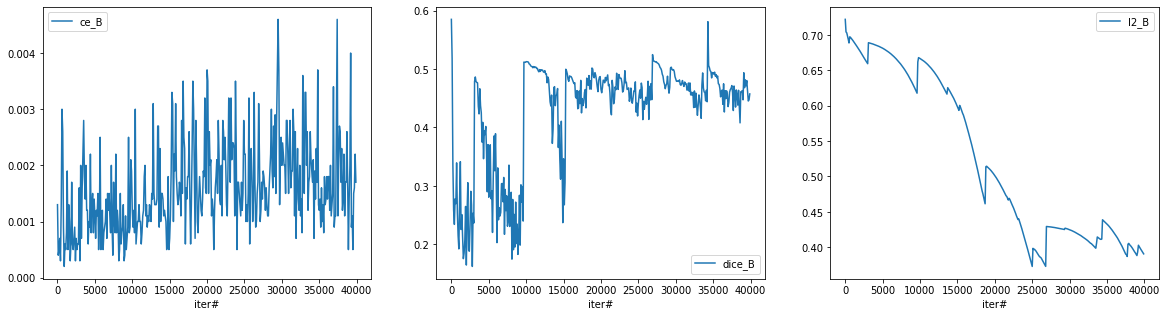

<AxesSubplot:xlabel='iter#'>

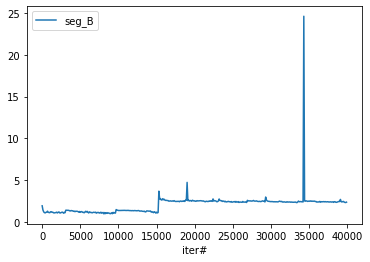

In [44]:
#Segmentation Loss
import matplotlib.pyplot as plt
columns = ['ce_B', 'dice_B', 'l2_B']
fig, axs = plt.subplots(1,3,figsize=(20,5))
for ax,col in zip(axs.ravel(),columns):
    if col != "iter#":
        df.plot(x ='iter#', y=col, kind = 'line',ax=ax)
plt.show()

df.plot(x ='iter#', y='seg_B', kind = 'line')

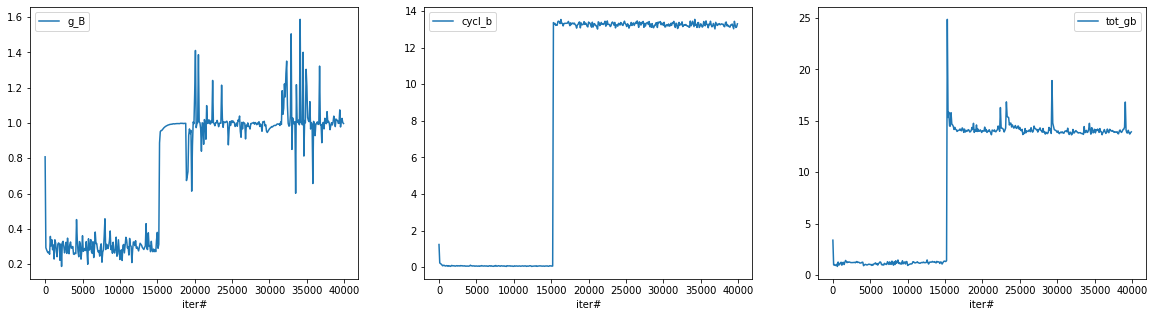

In [45]:
#Generator Loss B
columns = ['g_B', 'cycl_b', 'tot_gb']
fig, axs = plt.subplots(1,3,figsize=(20,5))
for ax,col in zip(axs.ravel(),columns):
    if col != "iter#":
        df.plot(x ='iter#', y=col, kind = 'line',ax=ax)
plt.show()

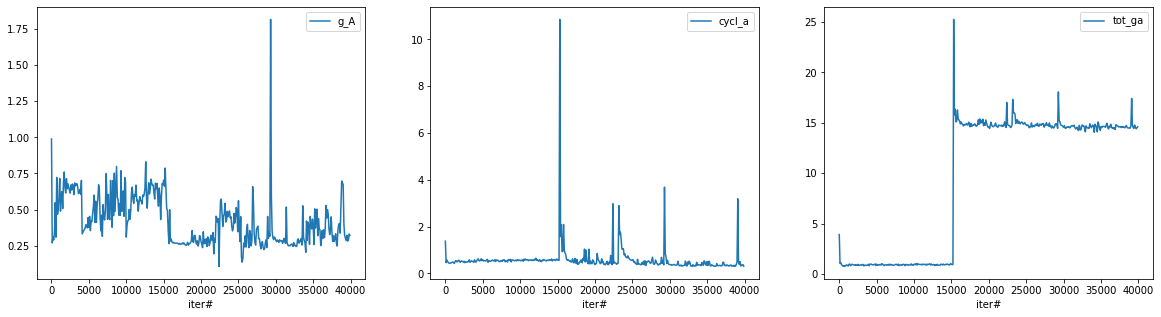

In [46]:
#Generator Loss A
columns = ['g_A', 'cycl_a', 'tot_ga']
fig, axs = plt.subplots(1,3,figsize=(20,5))
for ax,col in zip(axs.ravel(),columns):
    if col != "iter#":
        df.plot(x ='iter#', y=col, kind = 'line',ax=ax)
plt.show()

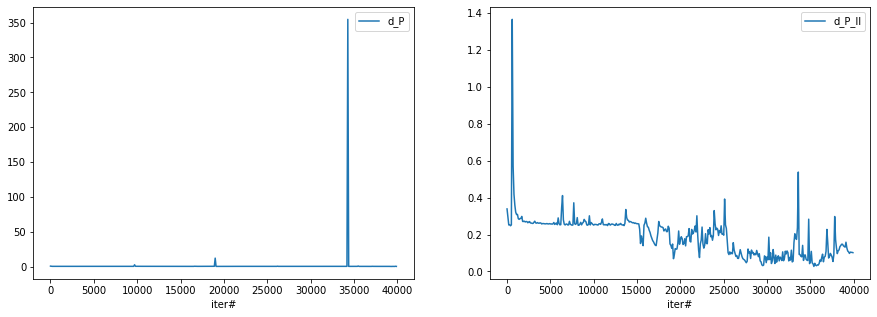

In [47]:
#Segmentation Discriminator Loss
columns = ['d_P', 'd_P_ll']
fig, axs = plt.subplots(1,2,figsize=(15,5))
for ax,col in zip(axs.ravel(),columns):
    if col != "iter#":
        df.plot(x ='iter#', y=col, kind = 'line',ax=ax)
plt.show()

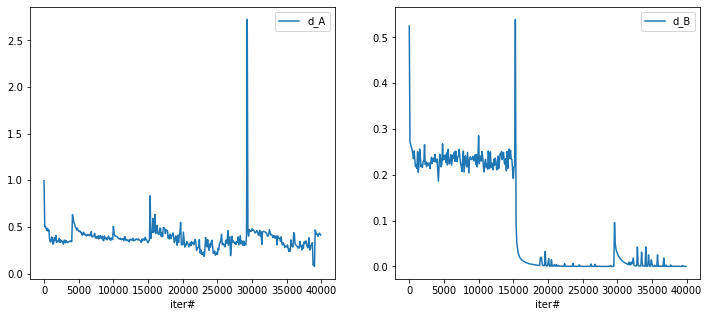

In [48]:
#Discriminator Loss
columns = ['d_A','d_B']
fig, axs = plt.subplots(1,2,figsize=(12,5))
for ax,col in zip(axs.ravel(),columns):
    if col != "iter#":
        df.plot(x ='iter#', y=col, kind = 'line',ax=ax)
plt.show()